In [1]:
import os
import pandas as pd
import pyagrum as gum
import pyagrum.skbn as skbn
import pyagrum.lib.notebook as gnb
from pyagrum.lib.bn2roc import showROC
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pyagrum.skbn import BNClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pyagrum.lib.explain as explain
from ipywidgets import interact, fixed
from pyagrum import BNLearner
import pyagrum as gum
from scipy.stats import chi2_contingency
import pyagrum.lib.bn2graph as gumb2g
import pyagrum.lib.explain as expl
from pyagrum.lib.discreteTypeProcessor import DiscreteTypeProcessor
import base64
import io
from itertools import product
import pyagrum.lib.bn_vs_bn as bnvsbn
import pyagrum.lib.bn_vs_bn as gcm
import pyagrum.lib.utils as gutils
import random
import numpy as np
import pyagrum.lib.explain as expl
from IPython.display import display



In [2]:
def dict2html(di1, di2=None):
  res = "<br/>".join([f"<b>{k:15}</b>:{v}" for k, v in di1.items()])
  if di2 is not None:
    res += "<br/><br/>"
    res += "<br/>".join([f"<b>{k:15}</b>:{v}" for k, v in di2.items()])
  return res

In [3]:
gum.config["notebook", "graph_layout"] = "dot"
gum.config["notebook", "graph_rankdir"] = "TB"

## Load data

In [4]:
os.chdir("/Volumes/GROUPS/HER/Onderzoek/Neurologie/VCI onderzoek/Malin Overmars/01_HARTBREIN/04_NETWORK")
#os.chdir("O:/Neurologie/VCI onderzoek/Malin Overmars/01_HARTBREIN/04_NETWORK")

In [5]:
df = pd.read_parquet("data/df.parquet", engine="pyarrow")
df_imp = pd.read_parquet("data/df_imp.parquet", engine="pyarrow")
bn_vars = pd.read_parquet("data/bn_vars.parquet", engine="pyarrow")

In [8]:
df_imp["CVA"] = df_imp["CVA"].replace(r"^\s*$", "Nee", regex=True)
df["CVA"] = df["CVA"].replace(r"^\s*$", "Nee", regex=True)

In [6]:
# Fill missing values in the STROKE_HISTORY column with 'No'
df_imp['STROKE_HISTORY'] = df_imp['STROKE_HISTORY'].fillna('No')

## Discretize

In [7]:
type_processor = DiscreteTypeProcessor(
  defaultDiscretizationMethod="kmeans", defaultNumberOfBins=8, discretizationThreshold=10
)

In [8]:
# creating a template explaining the variables proposed by the type_processor. This variables will be used by the learner
template = type_processor.discretizedTemplate(df_imp)
for i, n in template:
  print(f"{n:7} : {template.variable(i)}")

AGE     : AGE:Discretized(<(48.4928;55.475[,[55.475;60.9707[,[60.9707;66.0297[,[66.0297;70.5594[,[70.5594;75.2104[,[75.2104;80.1169[,[80.1169;85.5044[,[85.5044;92.4983)>)
SEX     : SEX:Labelized({Female|Male})
PTAU181 : PTAU181:Discretized(<(0.333625;1.20392[,[1.20392;1.7489[,[1.7489;2.48939[,[2.48939;3.54279[,[3.54279;5.70537[,[5.70537;7.79878[,[7.79878;9.68298[,[9.68298;11.0239)>)
NFL     : NFL:Discretized(<(4.43247;15.8966[,[15.8966;25.0419[,[25.0419;37.237[,[37.237;55.3145[,[55.3145;78.1853[,[78.1853;113.867[,[113.867;223.565[,[223.565;309.426)>)
GFAP    : GFAP:Discretized(<(21.5563;66.4309[,[66.4309;103.434[,[103.434;149.678[,[149.678;201.731[,[201.731;263.77[,[263.77;324.662[,[324.662;513.509[,[513.509;676.236)>)
AB40    : AB40:Discretized(<(8.19715;41.0889[,[41.0889;75.9967[,[75.9967;91.6572[,[91.6572;105.766[,[105.766;121.706[,[121.706;146.896[,[146.896;209.426[,[209.426;263.656)>)
AB42    : AB42:Discretized(<(0.510692;3.7309[,[3.7309;5.57105[,[5.57105;6.86507[,[6.86507;8.15975

In [9]:
#auditDict = type_processor.audit(df_imp)

#print()
#print("** audit **")
#for var in auditDict:
#  print(f"- {var} : ")
#  for k, v in auditDict[var].items():
#    print(f"    + {k} : {v}")

## Create structure of BN using expert knowledge

In [10]:
# Build the layer map: {1: [var1, var2], 2: [...], ..., 7: [...]}
layer_map = (
    bn_vars.groupby("LAYER")["VARIABLE NAME"]
    .apply(list)
    .to_dict()
)

In [11]:
bn = gum.BayesNet("LayeredBN")
node_ids = {}

for i in range(template.size()):
    var = template.variable(i)
    name = var.name()
    node_ids[name] = bn.add(var)  # only add once, from template
    

In [12]:
# Make sure keys are in the correct order
layer_keys = list(layer_map.keys())  # use list, not sorted, to preserve your domain-defined order

## Learn the structure within the forced layers

In [20]:
def build_bn(df, outcomes, layer_map, type_processor, score='K2', use_tabu=True, random_seed=42):
    """
    Builds a Bayesian Network and returns it, excluding 'L4 – Potential disease process markers'.

    Parameters:
    - df: pd.DataFrame, full imputed dataset
    - outcomes: list of str, outcome variables to retain
    - layer_map: dict, mapping of layer names to variable lists
    - type_processor: DiscreteTypeProcessor instance used for discretization
    - score: str, scoring function ('K2' or 'BIC')
    - use_tabu: bool, if True use local search with tabu list; else greedy hill climbing
    - random_seed: int, seed for reproducibility

    Returns:
    - bn: the learned Bayesian network
    """
    import random
    from itertools import product

    random.seed(random_seed)
    np.random.seed(random_seed)

    # Step 0: Exclude 'L4 – Potential disease process markers'
    layer_map_filtered = {k: v for k, v in layer_map.items() if k != 'L4 – Potential disease process markers'}
    excluded_vars = layer_map.get('L4 – Potential disease process markers', [])

    # Step 1: Drop excluded outcome variables and excluded biomarkers
    all_outcomes = set(layer_map_filtered[list(layer_map_filtered.keys())[-1]])
    drop_outcomes = list(all_outcomes - set(outcomes))

    df_reduced = df.drop(columns=drop_outcomes + excluded_vars, errors='ignore')
    variables_to_keep = df_reduced.columns.tolist()

    # Step 2: Build template from reduced dataframe
    template_reduced = type_processor.discretizedTemplate(df_reduced)

    # Step 3: Instantiate the learner
    learner = gum.BNLearner(df_reduced, template_reduced)

    if score.upper() == 'K2':
        learner.useScoreK2()
    elif score.upper() == 'BIC':
        learner.useScoreBIC()
        learner.useSmoothingPrior()
    else:
        raise ValueError("Unsupported score method: choose 'K2' or 'BIC'")

    if use_tabu:
        learner.useLocalSearchWithTabuList()
    else:
        learner.useGreedyHillClimbing()

    # Step 4: Build allowed arcs
    layer_keys = list(layer_map_filtered.keys())
    outcomes_layer = layer_keys[-1]
    outcomes_vars = set(layer_map_filtered[outcomes_layer]) & set(outcomes)

    allowed_arcs = []
    for i in range(len(layer_keys)):
        from_vars = layer_map_filtered[layer_keys[i]]
        for j in range(i, len(layer_keys)):
            to_vars = layer_map_filtered[layer_keys[j]]
            for parent, child in product(from_vars, to_vars):
                if parent in outcomes_vars and child in outcomes_vars and i == j:
                    continue  # disallow arcs within the outcome layer
                if parent in variables_to_keep and child in variables_to_keep:
                    allowed_arcs.append((parent, child))

    for parent in variables_to_keep:
        for child in variables_to_keep:
            if parent != child and (parent, child) not in allowed_arcs:
                learner.addForbiddenArc(parent, child)

    # Step 5: Learn the network
    bn = learner.learnBN()
    return bn

In [21]:
bn_cdr = build_bn(df_imp, outcomes=["CDR_INCREASE"], layer_map=layer_map, type_processor=type_processor, score="K2")
bn_mace = build_bn(df_imp, outcomes=["EVENT_MACE"], layer_map=layer_map, type_processor=type_processor, score="K2")
bn_joint = build_bn(df_imp, outcomes=["CDR_INCREASE", "EVENT_MACE"], layer_map=layer_map, type_processor=type_processor, score="K2")

In [22]:
# Define your ordered layers and assign them increasing color intensity
layer_order = [
    'L0 – Unmodifiable demographics',
    'L1 – Modifiable demograhpics / Lifestyle factors',
    'L2 – Cardiovascular risk factors',
    'L3 - Treatment status',
    'L4 – Potential disease process markers',
    'L5 - Imaging markers of neurovascular damage',
    'L6 – Current and previous cardiovascular diagnoses / Vascular interventions',
    'L7 - Functional status',
    'L8 – Outcomes'  # assumed typo in L7, but we keep both if present
]

# Create a color intensity map
layer_color_map = {
    name: i / (len(layer_order)-1)
    for i, name in enumerate(layer_order)
}

# Build the nodeColor dictionary
node_colors = {}
for layer_name, variables in layer_map.items():
    color_val = layer_color_map.get(layer_name, 0.5)  # fallback if unknown
    for var in variables:
        if var in bn_cdr.names():
            node_colors[var] = color_val

In [23]:
# Get the labels for CDR_INCR
cdr_labels = list(bn_joint.variable(bn_joint.idFromName("CDR_INCREASE")).labels())
mace_labels = list(bn_joint.variable(bn_joint.idFromName("EVENT_MACE")).labels())

## Illustration 1 - Trained networks for CDR with inference for CDR INCREASE

Given CDR_INCR, what are the posterior probabilities of upstream clinical factors?

In [25]:
gnb.sideBySide(
    *[
        gnb.getInference(bn_cdr, evs={"CDR_INCREASE": label}, nodeColor=node_colors, cmapNode=plt.get_cmap("BuPu")) for label in cdr_labels
    ],
    captions=[f"Inference given that CDR_INCREASE = {label}" for label in cdr_labels],
    ncols=1
)

In [27]:
await gutils.async_html2image(
    gnb.getSideBySide(
        *[
            gnb.getInference(
                bn_cdr,
                evs={"CDR_INCREASE": label},
                nodeColor=node_colors,
                cmapNode=plt.get_cmap("BuPu")
            )
            for label in cdr_labels
        ],
        captions=[f"Inference given that CDR_INCREASE = {label}" for label in cdr_labels],
        ncols=1
    ),
    "bn_cdr_inference.pdf"
)

## Illustration 1 - Trained networks for CDR and MACE with inference

In [29]:
gnb.sideBySide(
    *[
        gnb.getInference(
            bn_joint,
            evs={"CDR_INCREASE": cdr, "EVENT_MACE": mace},
            targets={},
            nodeColor=node_colors,
            cmapNode=plt.get_cmap("BuPu")
        )
        for cdr, mace in product(cdr_labels, mace_labels)
    ],
    captions=[
        f"Inference given that CDR_INCREASE = {cdr}, EVENT_MACE = {mace}"
        for cdr, mace in product(cdr_labels, mace_labels)
    ],
    ncols=1
)

In [31]:
await gutils.async_html2image(
    gnb.getSideBySide(
        *[
            gnb.getInference(
                bn_joint,
                evs={"CDR_INCREASE": cdr, "EVENT_MACE": mace},
                targets={},
                nodeColor=node_colors,
                cmapNode=plt.get_cmap("BuPu")
                
            )
            for cdr, mace in product(cdr_labels, mace_labels)
        ],
        captions=[
            f"Inference given that CDR_INCREASE = {cdr}, EVENT_MACE = {mace}"
            for cdr, mace in product(cdr_labels, mace_labels)
        ],
        ncols=1
    ),
    "bn_cdr_mace_inference.pdf"
)

In [ ]:
gnb.sideBySide(
  "<H3>CDR_INCREASE</H3>",
  "<H3>EVENT_MACE</H3>",
  bn_joint.cpt("CDR_INCREASE"),
  bn_joint.cpt("EVENT_MACE"),
  ncols=2,
)

In [39]:
gnb.sideBySide(
  "<H3>PATIENT_GROUP</H3>",
  "<H3>SVD_SCORE</H3>",
  bn_joint.cpt("STROKE_HISTORY"),
  bn_joint.cpt("SVD_SCORE"),
  ncols=2,
)

In [57]:
ClassfromBN = skbn.BNClassifier(significant_digit = 7)
ClassfromBN.fromTrainedModel(bn = bn_joint, targetAttribute = 'EVENT_MACE', targetModality = "1")

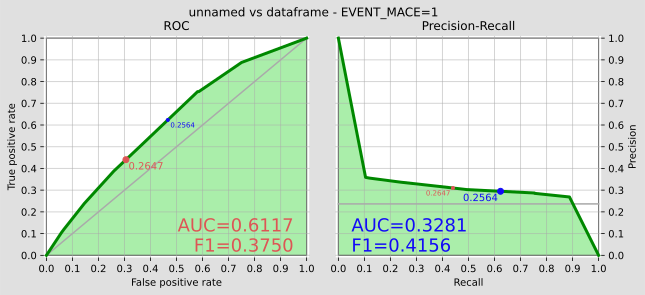

In [58]:
ClassfromBN.showROC_PR(df_imp)

In [53]:
ClassfromBN = skbn.BNClassifier(significant_digit = 7)
ClassfromBN.fromTrainedModel(bn = bn_joint, targetAttribute = 'CDR_INCREASE', targetModality = "1")

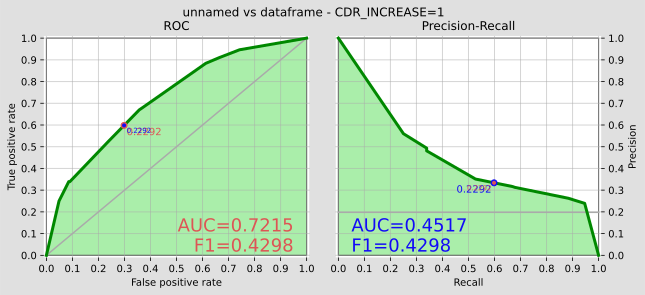

In [54]:
ClassfromBN.showROC_PR(df_imp)

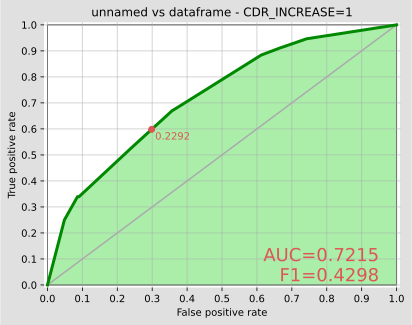

In [47]:
showROC(bn_joint, df_imp, "CDR_INCREASE", "1", show_progress=False);

## Illustration 2. Network with and without specialized biomarkers

In [76]:
def build_bn_exclude_layer(df, outcomes, layer_map, type_processor, exclude_layer=None, score='K2', use_tabu=True):
    """
    Builds a Bayesian Network while optionally excluding a specific layer.

    Parameters:
    - df: pd.DataFrame, full imputed dataset
    - outcomes: list of str, outcome variables to retain
    - layer_map: dict, mapping of layer names to variable lists
    - type_processor: DiscreteTypeProcessor instance used for discretization
    - exclude_layer: str, name of the layer to exclude (optional)
    - score: str, scoring function ('K2' or 'BIC')
    - use_tabu: bool, if True use local search with tabu list; else greedy hill climbing

    Returns:
    - bn: the learned Bayesian network
    """

    all_outcomes = set(layer_map[list(layer_map.keys())[-1]])
    drop_outcomes = all_outcomes - set(outcomes)
    exclude_vars = set(layer_map[exclude_layer]) if exclude_layer else set()

    df_reduced = df.drop(columns=drop_outcomes.union(exclude_vars))
    variables_to_keep = df_reduced.columns.tolist()

    template_reduced = type_processor.discretizedTemplate(df_reduced)
    learner = gum.BNLearner(df_reduced, template_reduced)

    if score.upper() == 'K2':
        learner.useScoreK2()
    elif score.upper() == 'BIC':
        learner.useScoreBIC()
        learner.useSmoothingPrior()
    else:
        raise ValueError("Unsupported score method: choose 'K2' or 'BIC'")

    if use_tabu:
        learner.useLocalSearchWithTabuList()
    else:
        learner.useGreedyHillClimbing()

    layer_keys = list(layer_map.keys())
    outcomes_layer = layer_keys[-1]
    outcomes_vars = set(layer_map[outcomes_layer]) & set(outcomes)

    allowed_arcs = []
    for i in range(len(layer_keys)):
        from_vars = layer_map[layer_keys[i]]
        if exclude_layer and layer_keys[i] == exclude_layer:
            continue
        for j in range(i, len(layer_keys)):
            to_vars = layer_map[layer_keys[j]]
            if exclude_layer and layer_keys[j] == exclude_layer:
                continue
            for parent, child in product(from_vars, to_vars):
                if parent in outcomes_vars and child in outcomes_vars and i == j:
                    continue
                if parent in variables_to_keep and child in variables_to_keep:
                    allowed_arcs.append((parent, child))

    for parent in variables_to_keep:
        for child in variables_to_keep:
            if parent != child and (parent, child) not in allowed_arcs:
                learner.addForbiddenArc(parent, child)

    bn = learner.learnBN()
    return bn

In [77]:
bn_with_biomarkers = build_bn_exclude_layer(df_imp, ["CDR_INCR", "EVENT_MACE"], layer_map, type_processor, exclude_layer=None)
bn_without_biomarkers = build_bn_exclude_layer(df_imp, ["CDR_INCR", "EVENT_MACE"], layer_map, type_processor, exclude_layer='L4 – Potential disease process markers')

In [78]:
ClassfromBN = skbn.BNClassifier(significant_digit = 7)
ClassfromBN.fromTrainedModel(bn = bn_with_biomarkers, targetAttribute = 'EVENT_MACE', targetModality = '1.0')

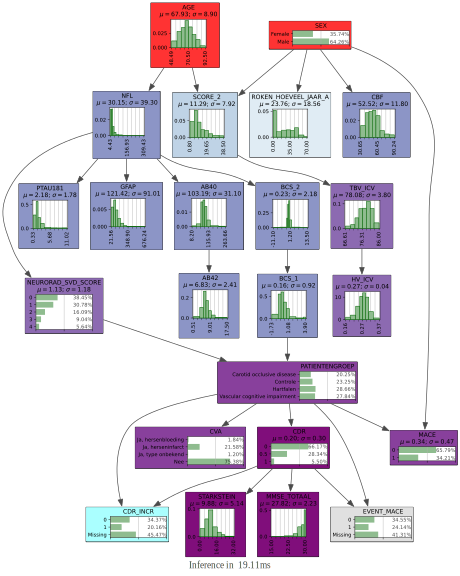

In [79]:
gnb.sideBySide(
    *[
        gnb.showInference(bn_with_biomarkers, nodeColor=node_colors, cmapNode=plt.get_cmap("BuPu"))
    ],
    captions=[f"Network with specialized biomarkers"]
)

As shown below, the specialized biomarkers are not in the learned path towards the two outcomes. Excluding layer 3, consisting of specialized biomarkers, does not have direct consequences for outcome predictions. However, they are involved in the network, but are not directly linked to the outcomes. 

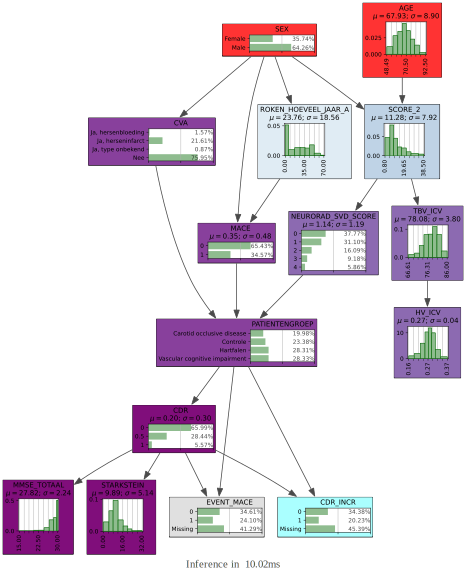

In [80]:
gnb.sideBySide(
    *[
        gnb.showInference(bn_without_biomarkers, nodeColor=node_colors, cmapNode=plt.get_cmap("BuPu"))
    ],
    captions=[f"Network without specialized biomarkers"]
    )

dataframe: 100%|██████████|


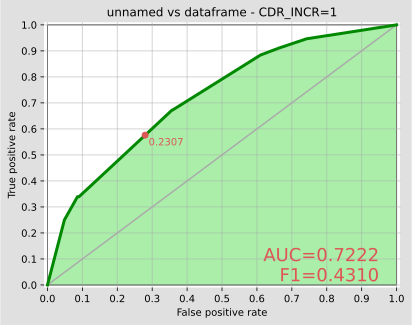

dataframe: 100%|██████████|


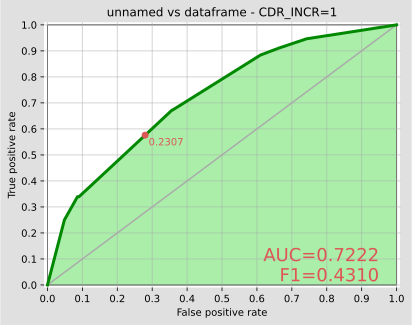

In [81]:
showROC(bn_with_biomarkers, df_imp, target ="CDR_INCR",label= "1", show_fig=True)
showROC(bn_without_biomarkers, df_imp, target="CDR_INCR", label= "1", show_fig=True)

dataframe: 100%|██████████|


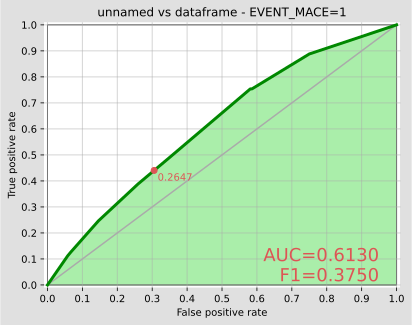

dataframe: 100%|██████████|


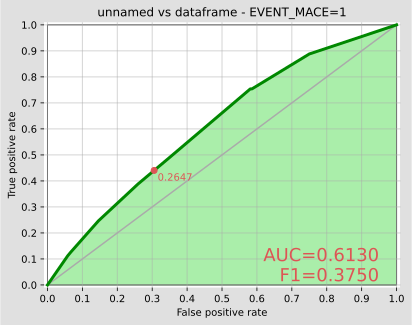

In [84]:
showROC(bn_with_biomarkers, df_imp, target ="EVENT_MACE",label= "1", show_fig=True)
showROC(bn_without_biomarkers, df_imp, target="EVENT_MACE", label= "1", show_fig=True)

In [82]:
gnb.showTensor(bn_joint.cpt(bn_joint.idFromName("CDR_INCR")), digits=2)

In [83]:
gnb.showTensor(bn_joint.cpt(bn_joint.idFromName("EVENT_MACE")), digits=2)

## Patientscenario's

In [78]:
gnb.sideBySide(
  *[
    gnb.getInference(bn_joint, evs={"PATIENTENGROEP": "Vascular cognitive impairment", "NEURORAD_NUMBER_OF_LOBAR_MICROBLEEDS": "2 or more", "FAM_TIA": "Ja", "NEURORAD_MODERATE_SEVERE_PVS": 1, "FAM_HERSENINFARCT": "Ja"},targets={"CDR_INCR", "EVENT_MACE"})
  ],
  captions=[
    f"Inference"
  ], ncols=1
)

## Modeling scenario's

A patient with:
* a family history of TIA
* CVA in history
* No microbleeds
* COD
* No perivascular spaces

... has 56% chance of MACE

In [ ]:
CDR = list(bn_joint["CDR"].labels())
MACE = list(bn_joint["MACE"].labels())
PATIENTENGROEP = list(bn_joint["PATIENTENGROEP"].labels())
NEURORAD_SVD_SCORE = list(bn_joint["NEURORAD_SVD_SCORE"].labels())

@interact(
    bn_joint=fixed(bn_joint), 
    CDR=CDR, 
    MACE=MACE,  
    PATIENTENGROEP=PATIENTENGROEP, 
    NEURORAD_SVD_SCORE=NEURORAD_SVD_SCORE, 
)
def evidence_impact(bn_joint, CDR, MACE, PATIENTENGROEP, NEURORAD_SVD_SCORE):
    evs = {
        "CDR": CDR,
        "MACE": MACE,
        "PATIENTENGROEP": PATIENTENGROEP,
        "NEURORAD_SVD_SCORE": NEURORAD_SVD_SCORE,
    }
    gnb.showInference(
        bn_joint, 
        evs=evs, 
        size="10!", 
        nodeColor=node_colors,
        cmapNode=plt.get_cmap("BuPu")
    )

interactive(children=(Dropdown(description='CDR', options=('0', '0.5', '1'), value='0'), Dropdown(description=…

In [86]:
# Save BN to a file
gum.saveBN(bn_joint, "bn_joint.bifxml")  # You can also use .net or .xdsl

## Fit the parameters (conditional probability tables) within the learned structure

## Show the structure with the learned CPTs

#### Show the structure with the posterior outcome probabilities

#### Show the structure of the outcome probabilities given evidence